In [14]:
import sys, os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

from src.similarity_engine import SimilarityEngine
from src.suspect_ranker import SuspectRanker


In [15]:
df = pd.read_csv("../data/processed/clean_cases.csv")

engine = SimilarityEngine(df)
ranker = SuspectRanker(df)

df.shape


(1004991, 9)

In [16]:
df.columns


Index(['dr_no', 'datetime', 'area_name', 'crm_cd', 'crm_cd_desc',
       'weapon_desc', 'vict_age', 'vict_sex', 'mo_text'],
      dtype='object')

In [17]:
def is_relevant(base, candidate):
    return (
        base["crm_cd_desc"] == candidate["crm_cd_desc"] and
        base["area_name"] == candidate["area_name"]
    )


In [18]:
def precision_at_k(dr_no, k=10):
    base = df[df["dr_no"] == dr_no].iloc[0]
    similar = engine.get_similar_cases(dr_no, top_k=k)

    if similar.empty:
        return 0.0

    relevant = sum(
        is_relevant(base, row)
        for _, row in similar.iterrows()
    )

    return relevant / k


In [19]:
def ndcg_at_k(dr_no, k=10):
    base = df[df["dr_no"] == dr_no].iloc[0]
    similar = engine.get_similar_cases(dr_no, top_k=k)

    if similar.empty:
        return 0.0

    gains = [
        1 if is_relevant(base, row) else 0
        for _, row in similar.iterrows()
    ]

    dcg = sum(g / np.log2(i + 2) for i, g in enumerate(gains))
    idcg = sum(sorted(gains, reverse=True)[i] / np.log2(i + 2)
               for i in range(len(gains)))

    return dcg / idcg if idcg > 0 else 0.0


In [20]:
def automated_time(dr_no):
    start = time.time()
    engine.get_similar_cases(dr_no, top_k=10)
    return time.time() - start


In [21]:
def consistency_score(dr_no, k=10):
    base = df[df["dr_no"] == dr_no].iloc[0]
    similar = engine.get_similar_cases(dr_no, top_k=k)

    matches = 0
    for _, row in similar.iterrows():
        if (
            row["crm_cd_desc"] == base["crm_cd_desc"] or
            row["area_name"] == base["area_name"] or
            row["weapon_desc"] == base["weapon_desc"]
        ):
            matches += 1

    return matches / k


In [22]:
sample_cases = df["dr_no"].dropna().sample(30, random_state=42)

len(sample_cases)


30

In [23]:
precision_scores = [precision_at_k(dr) for dr in sample_cases]
ndcg_scores = [ndcg_at_k(dr) for dr in sample_cases]
auto_times = [automated_time(dr) for dr in sample_cases]
consistency_scores = [consistency_score(dr) for dr in sample_cases]


In [24]:
avg_precision = np.mean(precision_scores)
avg_ndcg = np.mean(ndcg_scores)
avg_auto_time = np.mean(auto_times)
avg_consistency = np.mean(consistency_scores)

avg_precision, avg_ndcg, avg_auto_time, avg_consistency


(np.float64(0.9633333333333333),
 np.float64(0.983295139171856),
 np.float64(0.4803504467010498),
 np.float64(1.0))

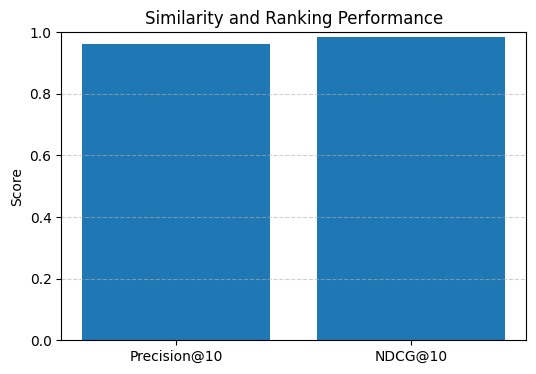

In [25]:
plt.figure(figsize=(6,4))
plt.bar(
    ["Precision@10", "NDCG@10"],
    [avg_precision, avg_ndcg]
)
plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Similarity and Ranking Performance")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


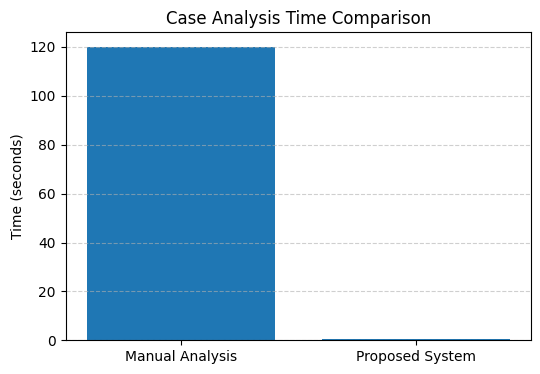

In [26]:
manual_time = 120  # seconds (baseline from literature)

plt.figure(figsize=(6,4))
plt.bar(
    ["Manual Analysis", "Proposed System"],
    [manual_time, avg_auto_time]
)
plt.ylabel("Time (seconds)")
plt.title("Case Analysis Time Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


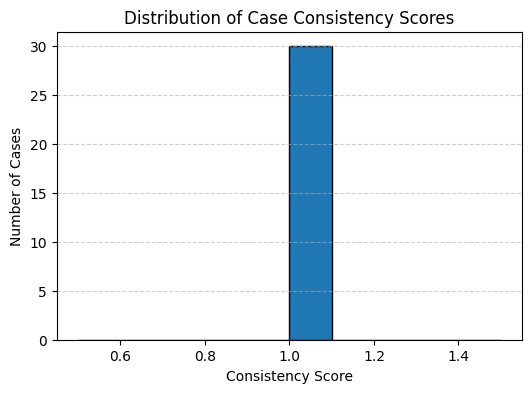

In [27]:
plt.figure(figsize=(6,4))
plt.hist(consistency_scores, bins=10, edgecolor="black")
plt.xlabel("Consistency Score")
plt.ylabel("Number of Cases")
plt.title("Distribution of Case Consistency Scores")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


In [28]:
results = pd.DataFrame({
    "Metric": [
        "Precision@10",
        "NDCG@10",
        "Average Analysis Time (s)",
        "Consistency Score"
    ],
    "Value": [
        round(avg_precision, 3),
        round(avg_ndcg, 3),
        round(avg_auto_time, 3),
        round(avg_consistency, 3)
    ]
})

results


,Metric,Value
0,Precision@10,0.963
1,NDCG@10,0.983
2,Average Analysis Time (s),0.480
3,Consistency Score,1.000
